# 1. Import the libraries.

In [1]:
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from gensim import corpora
from gensim.models import LdaModel
from sklearn.feature_extraction.text import TfidfVectorizer
import libs.util.file as fileUtil
import libs.extraction as extraction
import libs.exploration as exploration
import pandas as pd
from model.context import Language

# Download necessary NLTK data (if not already downloaded)
# Note: Catching LookupError is generally more robust for nltk.data.find
try:
    nltk.data.find("corpora/stopwords")
except LookupError:  # Catch LookupError as per NLTK's output
    nltk.download("stopwords")

try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")

try:
    nltk.data.find("taggers/averaged_perceptron_tagger")
except LookupError:
    nltk.download("averaged_perceptron_tagger")

try:
    nltk.data.find("corpora/wordnet")
except LookupError:
    nltk.download("wordnet")

try:
    nltk.data.find("corpora/brown")  # For some readability metrics
except LookupError:
    nltk.download("brown")

[nltk_data] Downloading package wordnet to /home/daniel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Create the context


In [2]:
from model.context import ContextBuilder, Context, FileType, UnitOfAnalysis

words_to_track = ["méxico", "mujeres"]
context: Context = (
    ContextBuilder()
    .with_language(Language.SPANISH)  # of the corpus
    .with_file_type(FileType.PDF)  # of the input data
    .with_unit_of_analysis(UnitOfAnalysis.WORDS)  # words, senteces, etc
    .with_words_to_track(words_to_track)
    .build()
)
context.print_properties()

--- Context Properties ---
language: Language.SPANISH
file_type: FileType.PDF
unit_of_analysis: UnitOfAnalysis.WORDS
data_directory: /home/daniel/projects/git/organizations/data-science-adventure/text-exploration/data
input_data_directory: /home/daniel/projects/git/organizations/data-science-adventure/text-exploration/data/input
file_to_process: None
extraction_context:
  - directory: /home/daniel/projects/git/organizations/data-science-adventure/text-exploration/data/extraction
  - suffix: -raw
pre_processing_context:
  - directory: /home/daniel/projects/git/organizations/data-science-adventure/text-exploration/data/pre_processing
feature_extraction_context:
  - directory: /home/daniel/projects/git/organizations/data-science-adventure/text-exploration/data/feature_extraction
words_to_track: ['méxico', 'mujeres']
--------------------------


# 3. PDF Extraction and Cleaning

This section handles reading multiple PDF files, extracting their text, and cleaning it. The cleaned texts PDFs will be saved to the extraction directory in .txt file for further analysis.

In [3]:
# Run the PDF processing pipeline
# Before running, make sure you have some PDF files in the 'data/input' folder
extraction.extract_pdfs_pipeline(context)

Processing PND_2025-2030_v250226_14.pdf...
Cleaned text saved to /home/daniel/projects/git/organizations/data-science-adventure/text-exploration/data/extraction/PND_2025-2030_v250226_14-raw.txt


# 4. Read cleaned documents

This section read the cleaned documents from the extraction directory and store it in memory in the documents variable for futher analysis. Also, it remove stop words from all documents and store in memory.

In [4]:

documents = fileUtil.read_documents(context)
extraction.remove_stop_words(documents, context.language)

# 5. Data Exploration Tasks

Now that we have our cleaned text, we can perform various linguistic analyses.

## 5.1 Word Frequency Lists
Analyzes the most frequent words in the text per Document.

          Word  Frequency
0   estrategia        261
1   desarrollo        255
2     nacional        249
3      mujeres        184
4       méxico        174
5       acceso        174
6     derechos        157
7   garantizar        147
8     personas        143
9   fortalecer        134
10      social        133
11    objetivo        130
12   servicios        128
13   bienestar        126
14        mide        121
15  porcentaje        118
16   población        117
17        país        116
18   indígenas        113
19       salud        105


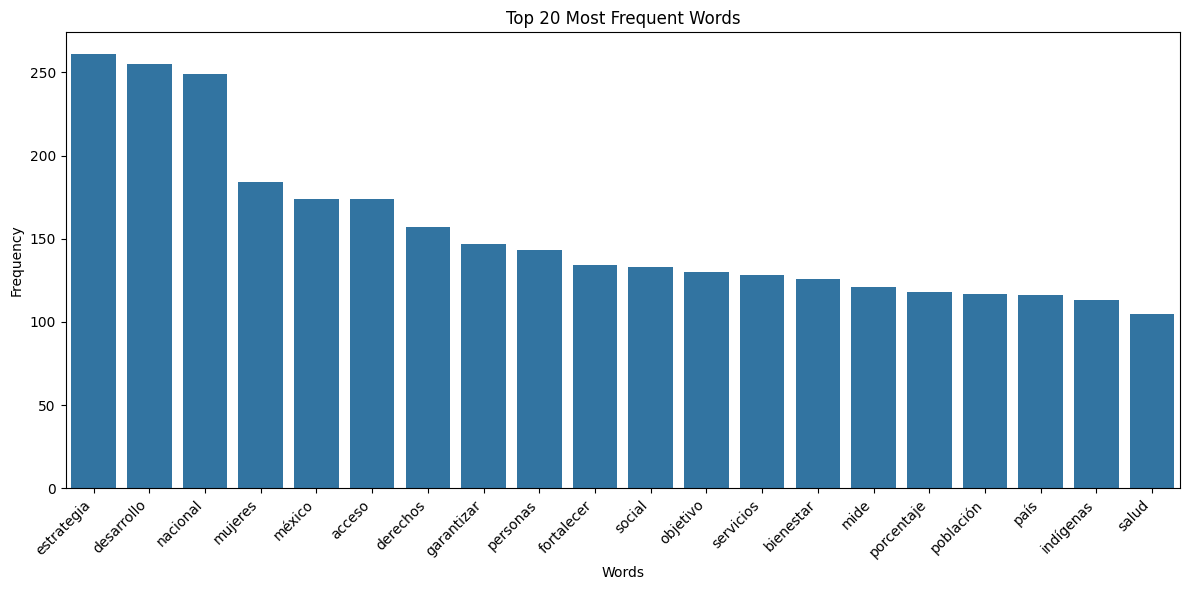

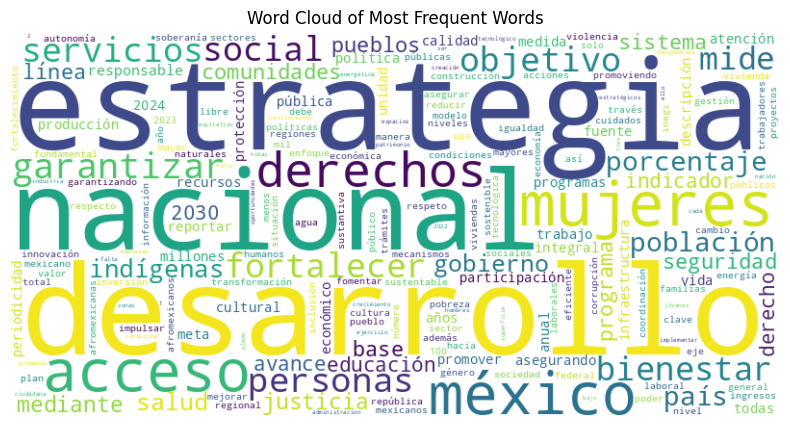

In [5]:
for document in documents:
    exploration.plot_frecuency_words(document.filtered_words)

## 5.2 N-gram Frequency
Analyzes the frequency of sequences of words (N-grams).

                     Bigram  Frequency
0                línea base         70
1                 base meta         67
2             unidad medida         66
3      responsable reportar         66
4           reportar avance         66
5   indígenas afromexicanas         54
6        periodicidad anual         54
7     comunidades indígenas         53
8               anual línea         53
9          descripción mide         46
10    estrategia fortalecer         38
11        medida porcentaje         38
12  porcentaje periodicidad         38
13                meta 2024         36
14                2024 2030         36
15         derechos humanos         35
16        pueblos indígenas         34
17        inegi responsable         34
18  indígenas afromexicanos         33
19      pueblos comunidades         33


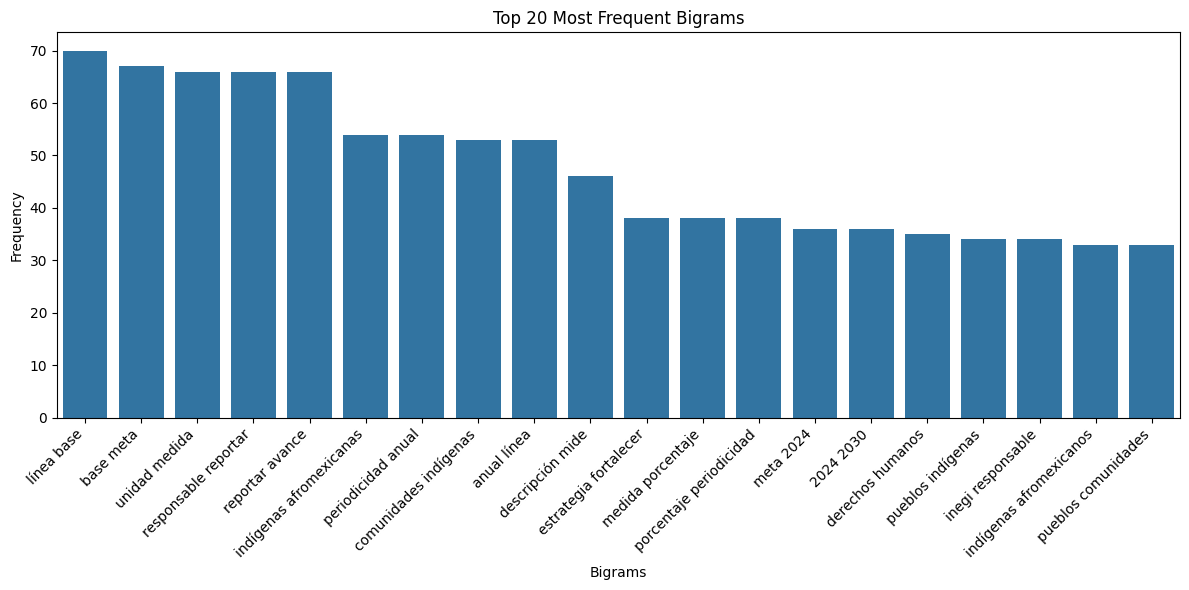

                                Trigram  Frequency
0                       línea base meta         66
1           responsable reportar avance         66
2              periodicidad anual línea         53
3                      anual línea base         53
4   comunidades indígenas afromexicanas         46
5              unidad medida porcentaje         38
6        medida porcentaje periodicidad         38
7                        base meta 2024         36
8                        meta 2024 2030         36
9            inegi responsable reportar         34
10        pueblos comunidades indígenas         33
11        porcentaje periodicidad anual         30
12      pueblos indígenas afromexicanos         24
13                       base meta 2022         15
14                       meta 2022 2030         15
15              sujetos derecho público         14
16          descripción mide porcentaje         13
17                       base meta 2023         13
18                       meta 2

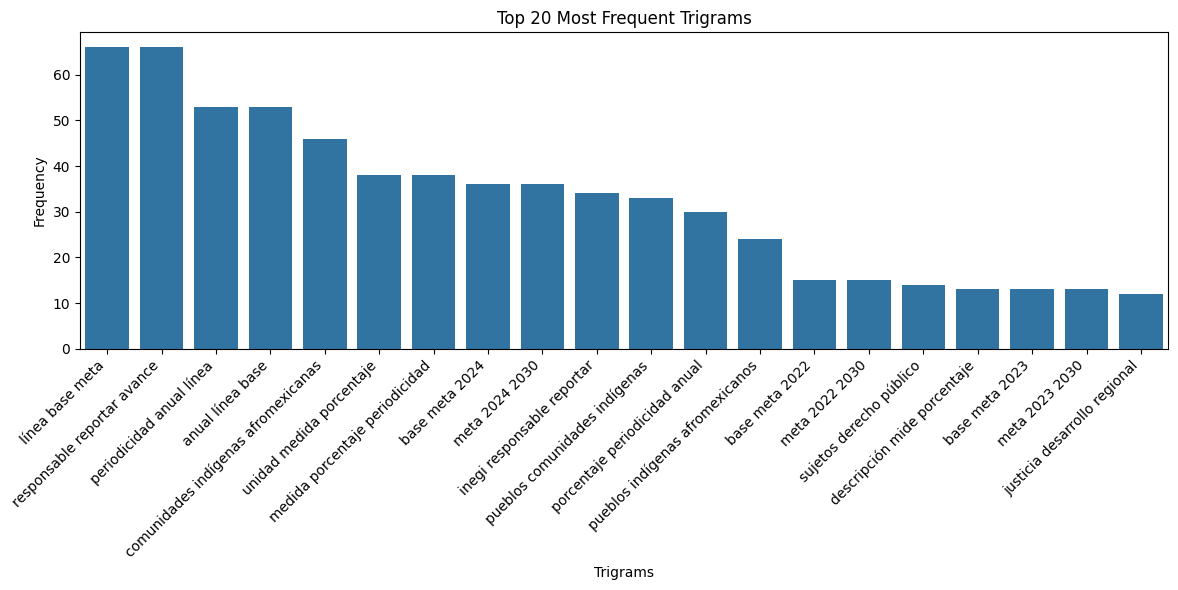

In [6]:
for document in documents:
    exploration.plot_ngram(document.filtered_words)

## 5.3 Part-of-Speech (POS) Tag Frequency

Identifies and counts the frequency of different grammatical categories (e.g., nouns, verbs, adjectives).


    Tag  Frequency
0    NN      17813
1    FW      11570
2    JJ       6719
3   NNS       2790
4     ,       2563
5    IN       2106
6     .       2078
7    CD       1630
8   VBP       1495
9    DT        945
10    :        743
11  VBZ        605
12   CC        468
13   RB        321
14   VB        283


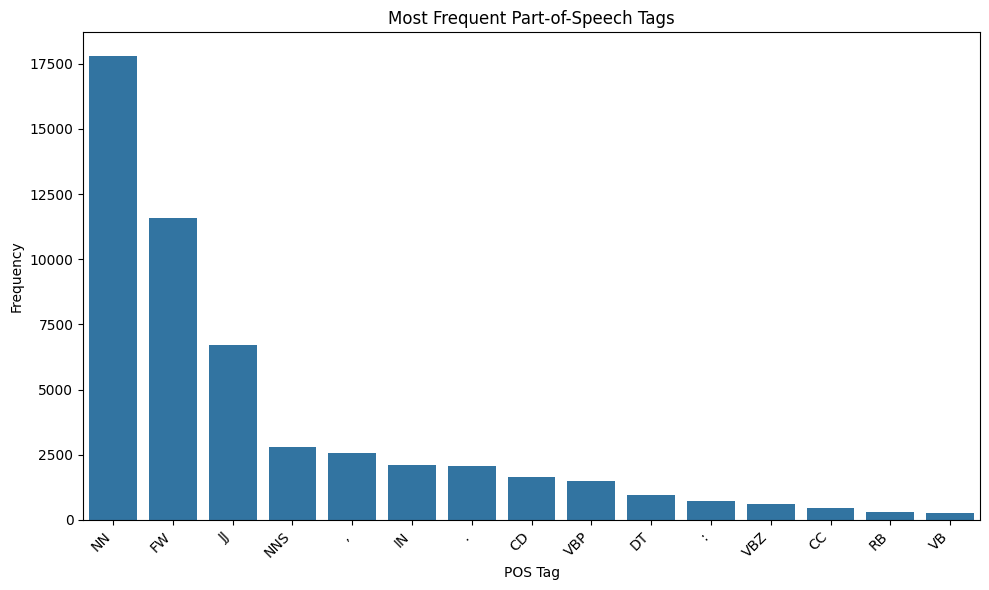

In [7]:
for document in documents:
    exploration.plot_pos_tag_frequency(document.words)

## 5.4 Concordance Analysis (Key Word in Context - KWIC)

Shows occurrences of a specific word with its surrounding context.


--- Concordance for 'méxico' ---
Displaying 10 of 174 matches:
imiento 129 visión largo plazo plan méxico 198 anexo 1 sistema nacional planea
nd guía objetivos acciones gobierno méxico próximos años objetivos consisten c
reafirma compromiso gobierno pueblo méxico gobernar honestidad democracia efic
transformación democrática pacífica méxico implicado décadas lucha popular ciu
te interés dignidad pueblo mexicano méxico vive momento clave historia pues ho
 nación inspira pnd raíces historia méxico afanes pueblo mexicano construir pa
transformación democrática pacífica méxico transformación pacífica iniciada go
da inversión extranjera actualmente méxico décimo segunda economía mundo sexto
truyeron 8 mil kilómetros vías unir méxico mitad manera artesanal tiempo récor
m tren interoceánico comunica golfo méxico océano pacífico línea k llega guate


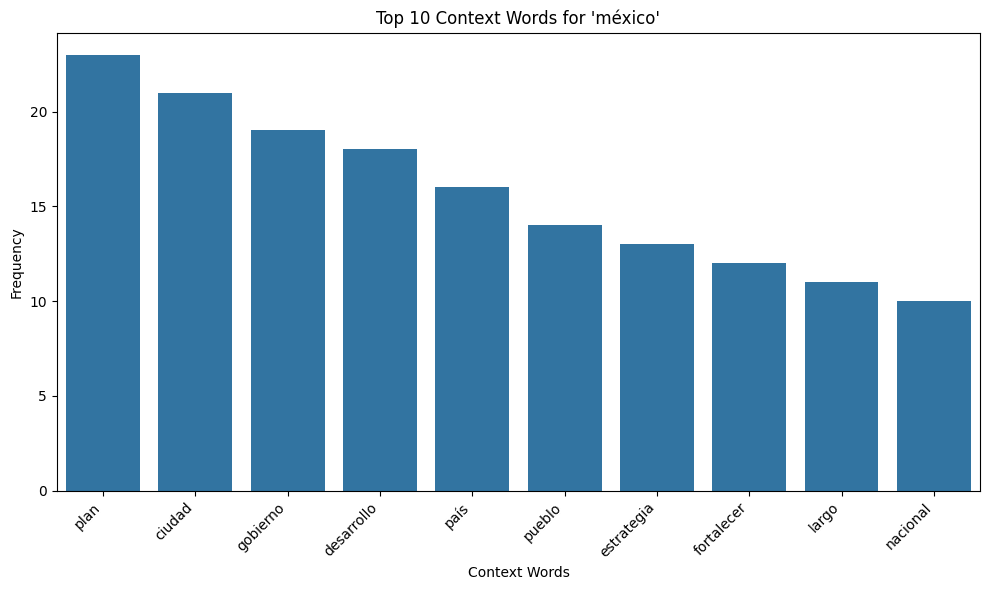


--- Concordance for 'mujeres' ---
Displaying 10 of 184 matches:
rsal 1 igualdad sustantiva derechos mujeres 74 eje transversal 2 innovación púb
ambio climático igualdad sustantiva mujeres derecho igualdad sustantiva históri
 igualdad sustantiva históricamente mujeres negado derechos plenos impulsamos i
ntable igualdad sustantiva derechos mujeres innovación pública desarrollo tecno
es programas bienestar nuevos todas mujeres 60 64 años apoyo bimestral reconoci
yo bimestral reconocimiento trabajo mujeres mexicanas todas niñas niños asisten
nte impidiendo herencia encargos 19 mujeres indígenas afromexicanos innovación 
nación igualdad sustantiva derechos mujeres prioridad ineludible puede haber tr
sticia género eliminación violencia mujeres cierre brechas salariales acceso op
a libre violencias así acceso salud mujeres horizonte 150 mil mujeres reconocer


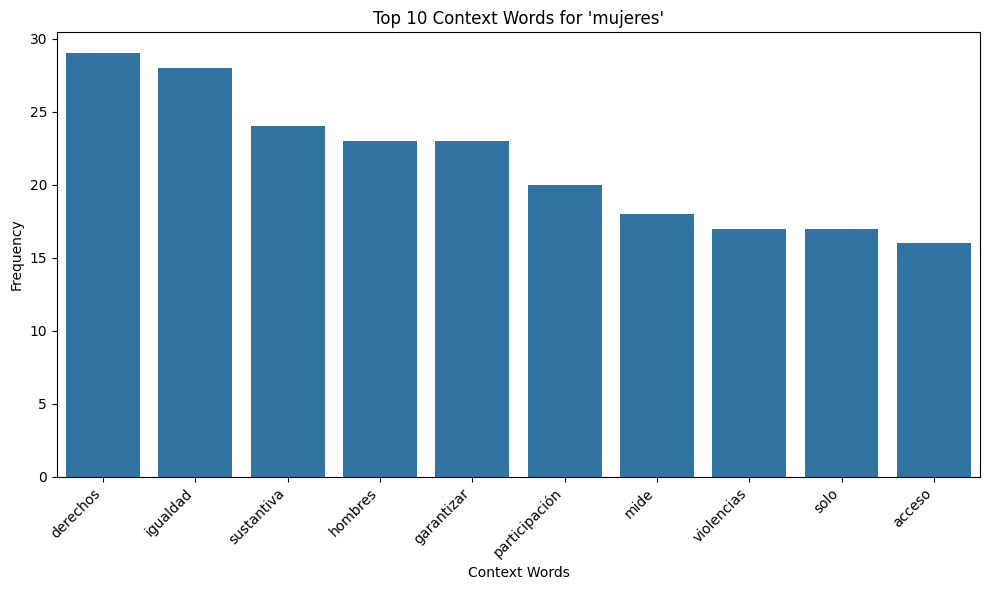

In [8]:
from nltk.text import Text

for document in documents:
    exploration.plot_concordance_analysis(
        context.words_to_track, document.filtered_words, context.language
    )

## 5.5 Collocation Analysis

Identifies words that frequently co-occur with each other.



--- Top 20 Collocations (Bigrams) ---
organizó vecinos
pequeñas medianas
vecinos resolverlo
austeridad republicana
lópez obrador
pequeños medianos
presuntamente violatorios
variación porcentual
otorgadas titulares
hechos presuntamente
términos reales
cargos elección
rezago habitacional
segundo piso
distritos riego
efecto invernadero
solicitan reciben
ahorro retiro
medianos productores
leyes generales


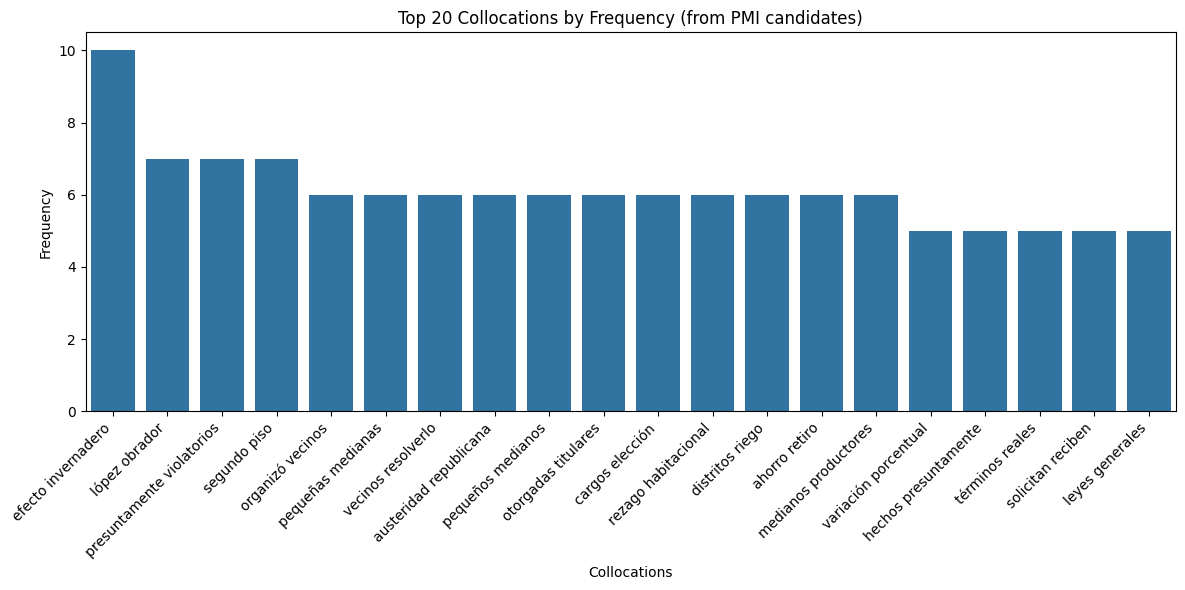

In [9]:
for document in documents:
    exploration.collocation_analysis(document.filtered_words)

# 5.6 Keyword Analysis

Identifies important keywords in the text. This often involves TF-IDF (Term Frequency-Inverse Document Frequency) or similar techniques. Since we have a single combined document, TF-IDF will show important words within that document relative to other potential documents (if we were comparing), or simply highlight relatively unique words within this text.

For a single document, simpler approaches like frequency (already done) or filtering common words are also used. For illustrative purposes, we'll use TF-IDF.


--- Top 20 Keywords (TF-IDF Scores) ---
estrategia: 0.3117
desarrollo: 0.3045
nacional: 0.2973
mujeres: 0.2197
acceso: 0.2078
méxico: 0.2078
derechos: 0.1875
garantizar: 0.1755
personas: 0.1719
fortalecer: 0.1600
social: 0.1588
bienestar: 0.1564
objetivo: 0.1552
servicios: 0.1528
mide: 0.1445
porcentaje: 0.1409
población: 0.1397
país: 0.1385
indígenas: 0.1349
salud: 0.1254


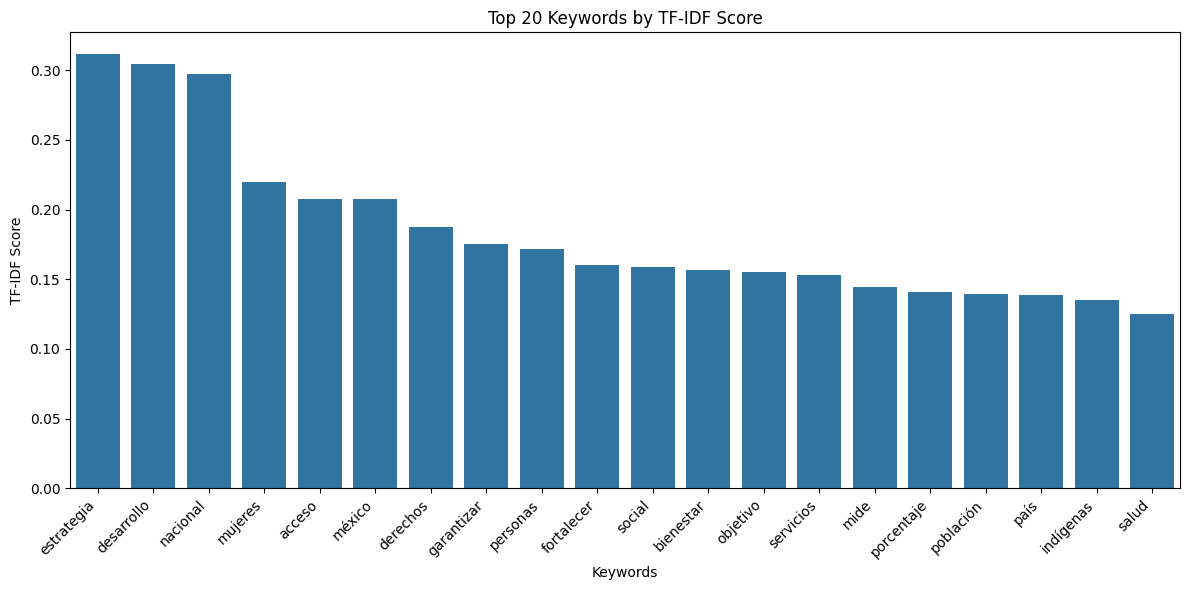

In [10]:
text_to_analyse = fileUtil.read_all_input_documents_as_one(
    context.extraction_context.directory
)
exploration.keyword_analysis(text_to_analyse, context.language)

# 5.7 Dispersion Analysis (Whelk Analysis)

Shows the distribution of specific words throughout the text.



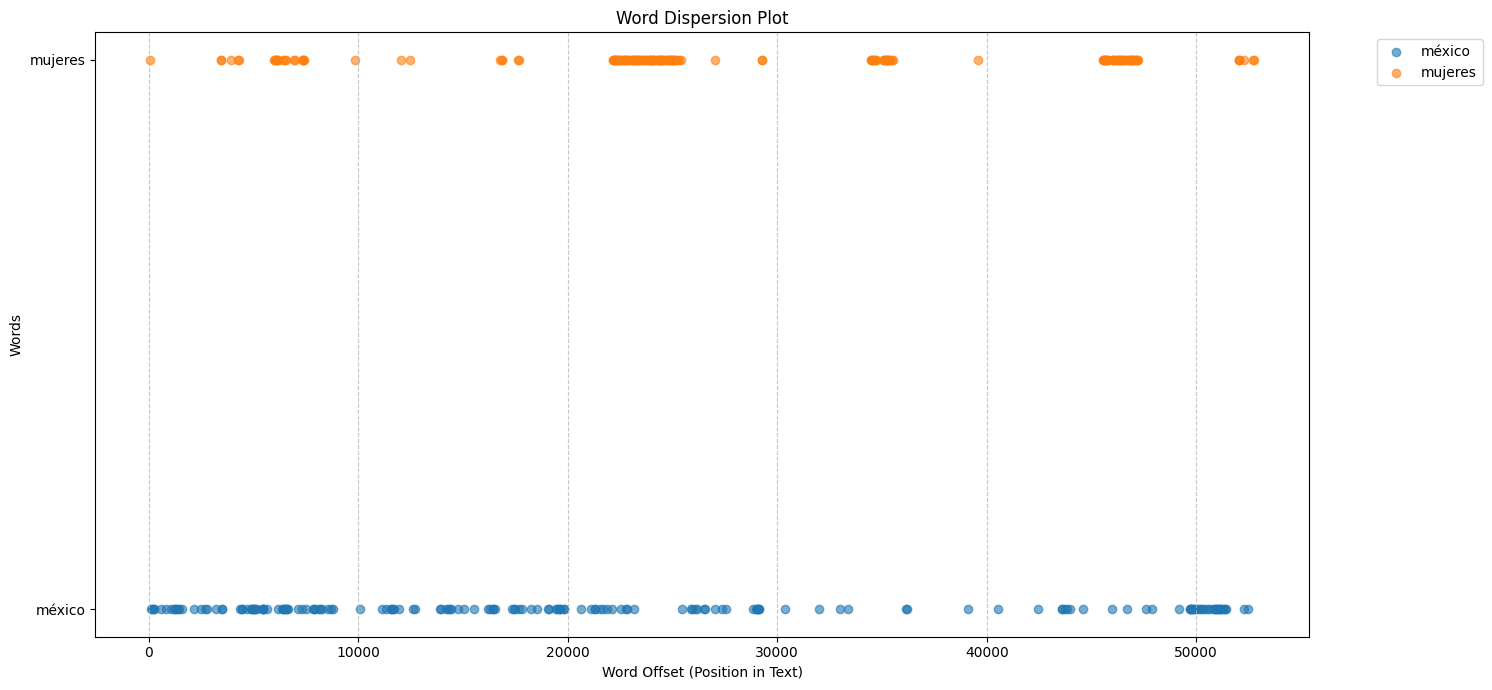

In [11]:
# Dispersion Analysis
for document in documents:
    exploration.dispersion_analysis(document.words, context.words_to_track)

## 5.8 Lexical Richness/Diversity Measures

Quantifies the variety of vocabulary in the text.


                                              Metric   Value
0                               Total Words (Tokens)   52815
1                               Unique Words (Types)    5763
2                             Type-Token Ratio (TTR)  0.1091
3  Filtered Words (Tokens - no stopwords/non-alph...   26491
4                      Unique Filtered Words (Types)    4919
5                    Filtered Type-Token Ratio (TTR)  0.1857

--- Lexical Richness/Diversity Measures ---
Total Words (Tokens): 52815
Unique Words (Types): 5763
Type-Token Ratio (TTR): 0.1091
Filtered Words (Tokens - no stopwords/non-alphanumeric): 26491
Unique Filtered Words (Types): 4919
Filtered Type-Token Ratio (TTR): 0.1857


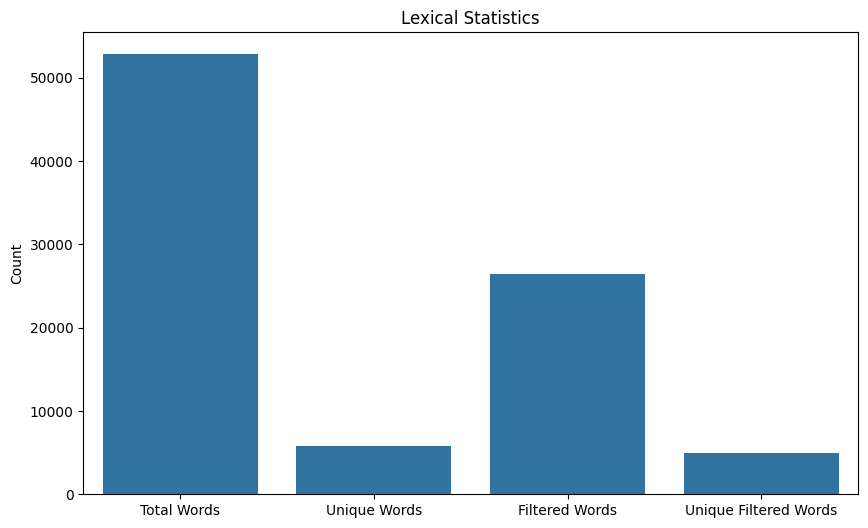

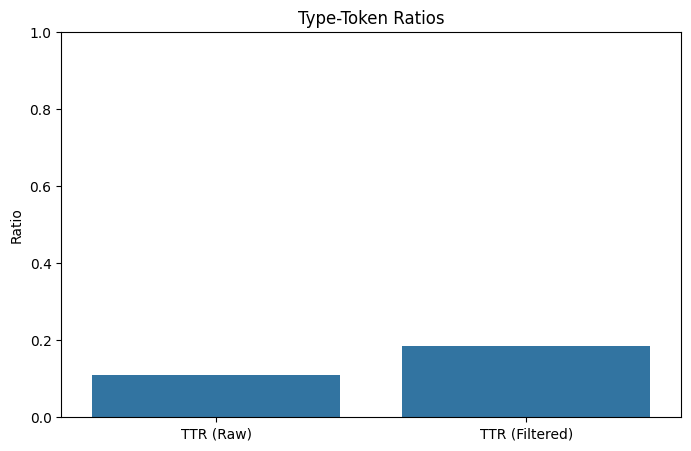

In [12]:
# Lexical Richness/Diversity Measures
for document in documents:
    exploration.lexical_diversity_analysis(document.words, document.filtered_words)

## 5.9 Readability and Complexity Analysis

Estimates how easy or difficult the text is to read.


--- Readability and Complexity Analysis ---
Flesch-Kincaid Grade Level: 19.33
Automated Readability Index (ARI): 16.06
Average Sentence Length: 21.61 words
Average Syllables per Word: 2.24


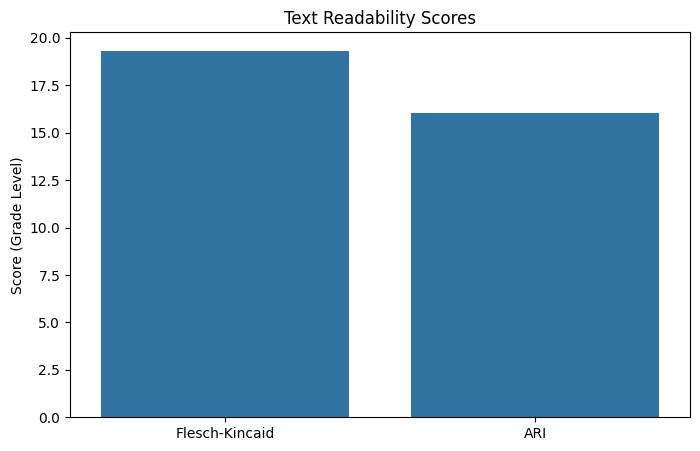

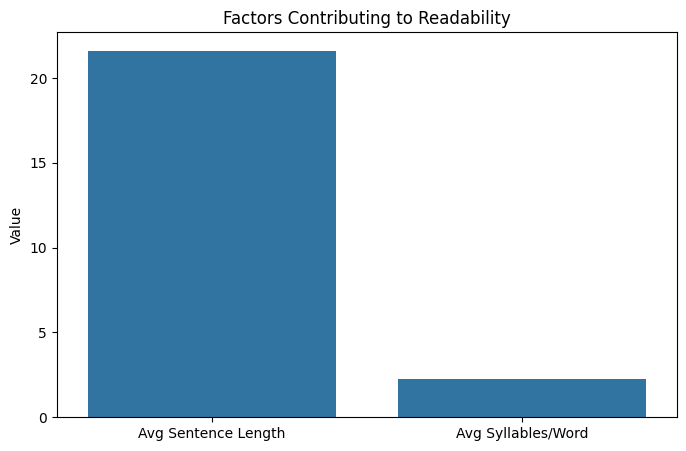

In [13]:

documents_stream = fileUtil.read_documents_as_stream(context.extraction_context.directory)

for document in fileUtil.read_documents_as_stream(context.extraction_context.directory):
    readability_scores = exploration.calculate_readability(document)
    print("\n--- Readability and Complexity Analysis ---")
    print(f"Flesch-Kincaid Grade Level: {readability_scores['flesch_kincaid']:.2f}")
    print(f"Automated Readability Index (ARI): {readability_scores['ari']:.2f}")
    print(f"Average Sentence Length: {readability_scores['avg_sentence_length']:.2f} words")
    print(f"Average Syllables per Word: {readability_scores['avg_syllables_per_word']:.2f}")

    # Visualization: Bar Chart of Readability Scores
    readability_metrics = ['Flesch-Kincaid', 'ARI']
    readability_values = [readability_scores['flesch_kincaid'], readability_scores['ari']]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=readability_metrics, y=readability_values)
    plt.title('Text Readability Scores')
    plt.ylabel('Score (Grade Level)')
    plt.show()

    # Visualization: Bar Chart of contributing factors
    contributing_metrics = ['Avg Sentence Length', 'Avg Syllables/Word']
    contributing_values = [readability_scores['avg_sentence_length'], readability_scores['avg_syllables_per_word']]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=contributing_metrics, y=contributing_values)
    plt.title('Factors Contributing to Readability')
    plt.ylabel('Value')
    plt.show()

## 5.10 Sentiment and Emotion Analysis (Initial Pass)

Performs a basic sentiment analysis using TextBlob. More advanced emotion analysis would typically require a specialized lexicon or a pre-trained model.


--- Sentiment Analysis (TextBlob) ---
Polarity: -0.03 (ranges from -1.0 to 1.0, where 1.0 is positive and -1.0 is negative)
Subjectivity: 0.40 (ranges from 0.0 to 1.0, where 0.0 is objective and 1.0 is subjective)
Overall Sentiment: Neutral


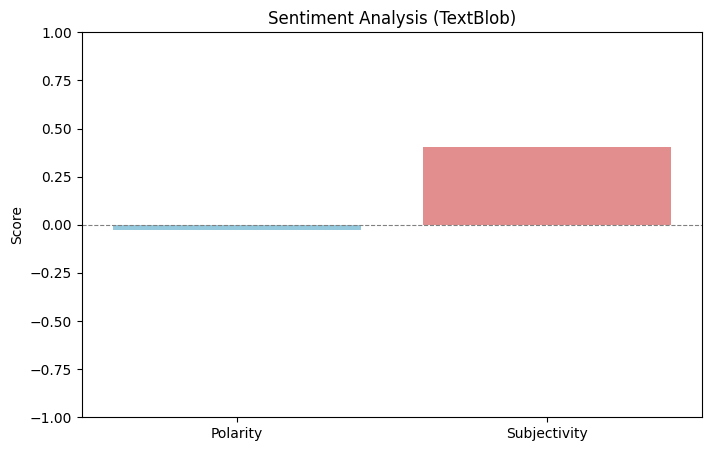

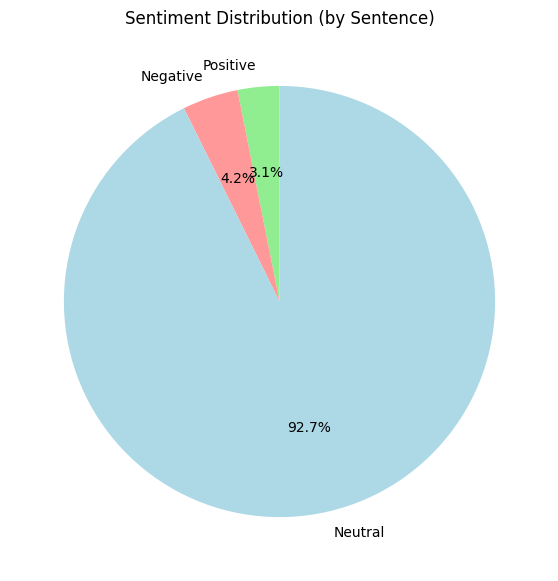

In [14]:
# Sentiment Analysis using TextBlob

for document in fileUtil.read_documents_as_stream(context.extraction_context.directory):
    sentences = sent_tokenize(document)
    blob = TextBlob(document)
    sentiment = blob.sentiment

    print("\n--- Sentiment Analysis (TextBlob) ---")
    print(
        f"Polarity: {sentiment.polarity:.2f} (ranges from -1.0 to 1.0, where 1.0 is positive and -1.0 is negative)"
    )
    print(
        f"Subjectivity: {sentiment.subjectivity:.2f} (ranges from 0.0 to 1.0, where 0.0 is objective and 1.0 is subjective)"
    )

    # Interpret sentiment
    if sentiment.polarity > 0.1:
        sentiment_label = "Positive"
    elif sentiment.polarity < -0.1:
        sentiment_label = "Negative"
    else:
        sentiment_label = "Neutral"

    print(f"Overall Sentiment: {sentiment_label}")

    # Visualization: Bar Chart for Polarity and Subjectivity
    sentiment_metrics = ["Polarity", "Subjectivity"]
    sentiment_values = [sentiment.polarity, sentiment.subjectivity]

    plt.figure(figsize=(8, 5))
    sns.barplot(
        x=sentiment_metrics,
        y=sentiment_values,
        palette=["skyblue", "lightcoral"],
        hue=sentiment_metrics,
        legend=False,
    )
    plt.title("Sentiment Analysis (TextBlob)")
    plt.ylabel("Score")
    plt.ylim(-1.0, 1.0)  # Polarity ranges from -1 to 1, Subjectivity from 0 to 1
    plt.axhline(0, color="grey", linestyle="--", linewidth=0.8)
    plt.show()

    # Simple pie chart for sentiment distribution (if we had more granularity)
    # For a single polarity score, we can just visualize the score itself.
    # To show "Positive/Negative/Neutral" distribution, we'd need to classify sentences.

    sentence_sentiments = [
        TextBlob(sentence).sentiment.polarity for sentence in sentences
    ]
    positive_sentences = sum(1 for s in sentence_sentiments if s > 0.1)
    negative_sentences = sum(1 for s in sentence_sentiments if s < -0.1)
    neutral_sentences = sum(1 for s in sentence_sentiments if -0.1 <= s <= 0.1)

    sentiment_counts = {
        "Positive": positive_sentences,
        "Negative": negative_sentences,
        "Neutral": neutral_sentences,
    }

    if sum(sentiment_counts.values()) > 0:
        plt.figure(figsize=(7, 7))
        plt.pie(
            sentiment_counts.values(),
            labels=sentiment_counts.keys(),
            autopct="%1.1f%%",
            startangle=90,
            colors=["#90ee90", "#ff9999", "#add8e6"],
        )
        plt.title("Sentiment Distribution (by Sentence)")
        plt.show()
    else:
        print("Not enough sentences to generate sentiment distribution.")

## 5.11 Topic Modeling (Probabilistic)

Uses Latent Dirichlet Allocation (LDA) to discover abstract "topics" in the text.


--- Topic Modeling (LDA) with 5 Topics ---
Topic 0: 0.011*"mujeres" + 0.011*"bienestar" + 0.011*"desarrollo" + 0.010*"acceso" + 0.008*"estrategia"
Topic 1: 0.027*"méxico" + 0.022*"plan" + 0.017*"sectores" + 0.014*"país" + 0.013*"crecimiento"
Topic 2: 0.017*"derechos" + 0.016*"propuestas" + 0.014*"así" + 0.013*"indígenas" + 0.012*"pnd"
Topic 3: 0.065*"programa" + 0.058*"nacional" + 0.024*"desarrollo" + 0.018*"eje" + 0.015*"especial"
Topic 4: 0.028*"productiva" + 0.015*"país" + 0.013*"regiones" + 0.012*"industrial" + 0.012*"expansión"


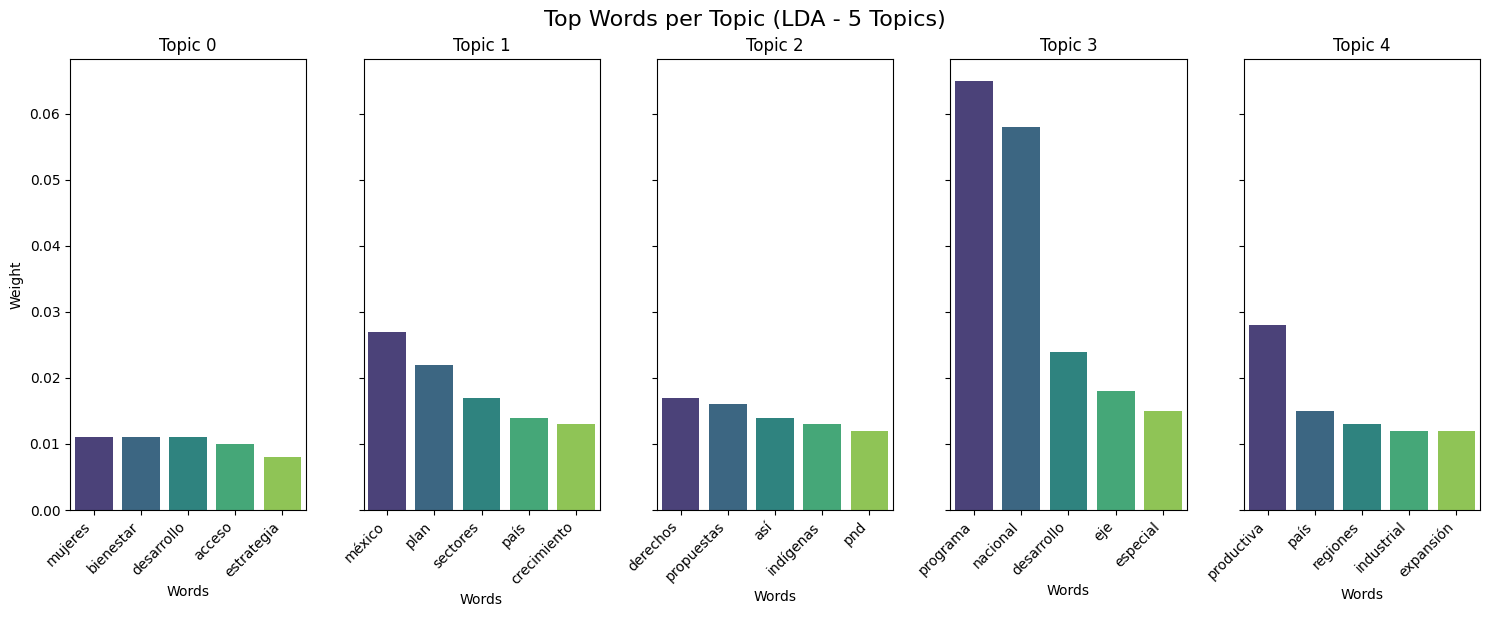

In [21]:
# Topic Modeling (LDA)
# Prepare data for LDA


for document in documents:

    texts_for_lda = [
        [
            word
            for word in word_tokenize(sentence)
            if word.isalnum()
            and word not in extraction.get_stop_words(context.language)
        ]
        for sentence in document.sentences
        if len(word_tokenize(sentence)) > 0
    ]

    # Create a dictionary and corpus
    dictionary = corpora.Dictionary(texts_for_lda)
    corpus = [dictionary.doc2bow(text) for text in texts_for_lda]

    # Train the LDA model
    num_topics = 5  # You can adjust the number of topics
    lda_model = LdaModel(
        corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=1
    )

    print(f"\n--- Topic Modeling (LDA) with {num_topics} Topics ---")
    topics = lda_model.print_topics(num_words=5)  # Show top 5 words per topic
    for topic_id, topic_words in topics:
        print(f"Topic {topic_id}: {topic_words}")

    # Visualization: Bar Chart of Top Words per Topic
    fig, axes = plt.subplots(ncols=num_topics, figsize=(15, 6), sharey=True)
    axes = axes.flatten()

    for i, topic in enumerate(topics):
        topic_id, topic_words_str = topic
        # Parse the topic words string (e.g., '0.050*"word1" + 0.040*"word2"')
        words_weights = re.findall(r'(\d+\.\d+)\*"(\w+)"', topic_words_str)
        words = [word for weight, word in words_weights]
        weights = [float(weight) for weight, word in words_weights]

        if words:
            sns.barplot(x=words, y=weights, ax=axes[i], palette="viridis", hue=words)
            axes[i].set_title(f"Topic {topic_id}")
            axes[i].set_xlabel("Words")
            axes[i].set_ylabel("Weight")

            # Get the number of words to create tick positions
            tick_positions = range(len(words))

            # Explicitly set the tick positions
            axes[i].set_xticks(tick_positions)

            # Now set the tick labels with rotation and alignment
            axes[i].set_xticklabels(words, rotation=45, ha="right")
        else:
            axes[i].set_title(f"Topic {topic_id} (No words found)")
            axes[i].text(
                0.5,
                0.5,
                "N/A",
                horizontalalignment="center",
                verticalalignment="center",
                transform=axes[i].transAxes,
            )

    plt.tight_layout()
    plt.suptitle(f"Top Words per Topic (LDA - {num_topics} Topics)", y=1.02, fontsize=16)
    plt.show()

## 5.12 Named Entity Recognition (NER) and Entity Frequency

Identifies and categorizes named entities (e.g., persons, organizations, locations). Requires spaCy.


--- Named Entity Recognition (NER) Label Frequency ---
LOC: 138
MISC: 90
PER: 64
ORG: 41

--- Top 10 PERSON Entities ---

--- Top 10 ORG Entities ---
cfe: 8
información: 4
ocde: 3
demás: 2
pemex: 2
pt: 2
sii: 2
construcción: 2
........................................................................................................: 1
además: 1

--- Top 10 GPE Entities ---


/tmp/ipykernel_541015/3139216669.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette='coolwarm')


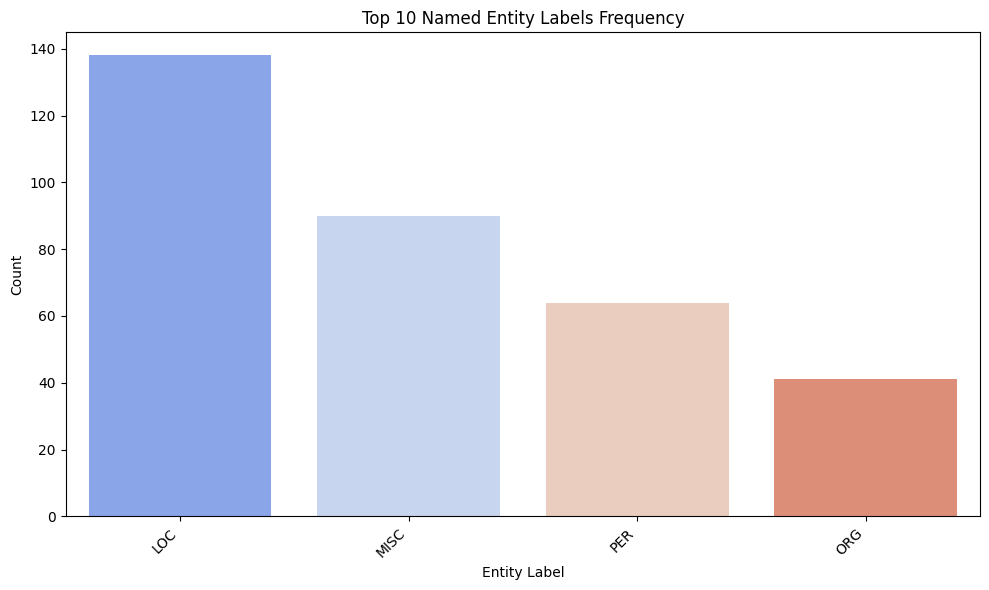

No PERSON entities found for visualization.


/tmp/ipykernel_541015/3139216669.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=counts, palette='Paired')


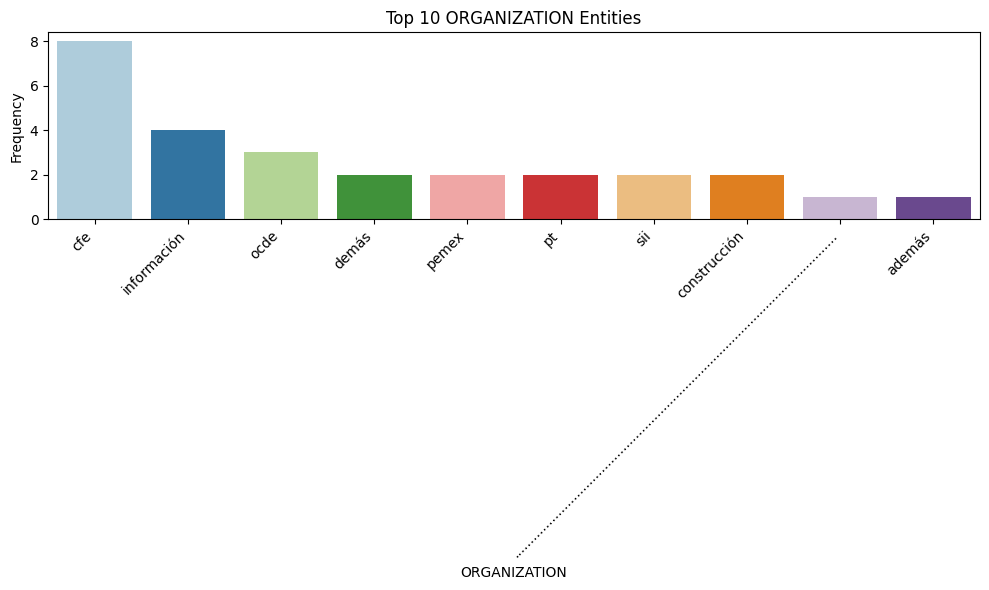

No GEOPOLITICAL ENTITY entities found for visualization.


In [16]:
from libs.util.text import load_ner_model

for document in fileUtil.read_documents_as_stream(context.extraction_context.directory):

    nlp = load_ner_model(context.language)
    # NER
    doc = nlp(document)

    # Extract entities and their labels
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Count frequency of each entity label
    entity_label_counts = Counter(label for text, label in entities)
    print("\n--- Named Entity Recognition (NER) Label Frequency ---")
    for label, count in entity_label_counts.most_common(10):
        print(f"{label}: {count}")

    # Count frequency of specific entity types (e.g., PERSON, ORG, GPE)
    person_entities = Counter(ent.text for ent in doc.ents if ent.label_ == "PERSON")
    org_entities = Counter(ent.text for ent in doc.ents if ent.label_ == "ORG")
    gpe_entities = Counter(ent.text for ent in doc.ents if ent.label_ == "GPE") # Geopolitical Entity (countries, cities, states)

    print("\n--- Top 10 PERSON Entities ---")
    for entity, count in person_entities.most_common(10):
        print(f"{entity}: {count}")

    print("\n--- Top 10 ORG Entities ---")
    for entity, count in org_entities.most_common(10):
        print(f"{entity}: {count}")

    print("\n--- Top 10 GPE Entities ---")
    for entity, count in gpe_entities.most_common(10):
        print(f"{entity}: {count}")

    # Visualization: Bar Chart of Top Entity Labels
    if entity_label_counts:
        labels = [label for label, count in entity_label_counts.most_common(10)]
        counts = [count for label, count in entity_label_counts.most_common(10)]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=labels, y=counts, palette='coolwarm')
        plt.title('Top 10 Named Entity Labels Frequency')
        plt.xlabel('Entity Label')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No entities found for visualization.")


    # Visualization: Bar Charts for specific entity types (e.g., PERSON, ORG)
    def plot_top_entities(entity_counter, title, num_to_plot=10):
        if entity_counter:
            entities_to_plot = entity_counter.most_common(num_to_plot)
            names = [name for name, count in entities_to_plot]
            counts = [count for name, count in entities_to_plot]
            plt.figure(figsize=(10, 6))
            sns.barplot(x=names, y=counts, palette='Paired')
            plt.title(f'Top {num_to_plot} {title} Entities')
            plt.xlabel(title)
            plt.ylabel('Frequency')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print(f"No {title} entities found for visualization.")

    plot_top_entities(person_entities, 'PERSON')
    plot_top_entities(org_entities, 'ORGANIZATION')
    plot_top_entities(gpe_entities, 'GEOPOLITICAL ENTITY')